In [12]:
import gym
import random  

In [13]:
env = gym.make('CartPole-v0')

In [14]:
states = env.observation_space.shape[0]
actions = env.action_space.n
print(states, actions, env.action_space.sample())

4 2 0


In [15]:
env.observation_space.sample()

array([ 1.2733034e+00,  8.0114494e+37, -3.5391843e-01, -1.6309859e+38],
      dtype=float32)

In [16]:
env.reset()

array([-0.04170442,  0.0268412 , -0.01016623,  0.04803184])

In [17]:
episodes = 10
for episode in range(1, episodes + 1):
    state = env.reset()
    done = False
    score = 0
    while not done:
        env.render()
        action = random.choice([0, 1])
        next_state, reward, done, info = env.step(action)
        score += reward
    print('Episode:{} Socre:{}'.format(episode, score))

Episode:1 Socre:16.0
Episode:2 Socre:42.0
Episode:3 Socre:12.0
Episode:4 Socre:21.0
Episode:5 Socre:11.0
Episode:6 Socre:32.0
Episode:7 Socre:63.0
Episode:8 Socre:30.0
Episode:9 Socre:29.0
Episode:10 Socre:24.0


In [18]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1, states)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [19]:
model = build_model(states, actions)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_10 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________


In [15]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import collections

class DQNAgent():
    def __init__(self, state_n, action_n):
        self.memory = collections.deque(maxlen = 5000)
        self.batch_size = 20
               
        self.epsilon = 1.0               # 0.99 probability of exploring, it might decrease during training
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995       

        self.gamma = 0.95                # discount factor
        self.batch_size = 32
        self.step = 0
        
        self.state_n = state_n
        self.action_n = action_n
        self.learning_rate = 0.001        # 0.0005
        
        self.model = self.__build_model() 
        self.C = 10                       # synchronize the model to target per 50 step(target sync frequence) 
        self.target_model = self.copy(self.model)  # todo: copy 
        self.path = './save/cartpole-dqn.h5'
    
    def __build_model(self):
        model = Sequential()
        model.add(Dense(24, activation='relu', input_dim=self.state_n))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_n, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr = self.learning_rate))
        return model
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_n)
        states = np.expand_dims(state, axis=0)         # state = np.reshape(state, [1, states_n])
        q_actions = self.model.predict(states)         # [[q_action1, q_action2, ...]]      
        q_actions = np.squeeze(q_actions, axis=0)      # q_actions = q_actions[0]
        action = np.argmax(q_actions)
        return action
    
    def memorize(self, state, action, reward, next_state, done):
        reward = reward if not done else -10           # 如果结束是否进行惩罚措施
        self.memory.append((state, action, reward, next_state, done)) 
 
    def learn(self):
        if len(self.memory) < self.batch_size: return
        
        if self.step % self.C == 0:
            self.target_model = self.copy(self.model) # todo 
    
        mini_batch = random.sample(self.memory, self.batch_size)
        states = []
        q_actions_targets = []
        for state, action, reward, next_state, done in mini_batch:
            target_value = reward
            if not done:
                next_states = np.expand_dims(next_state, axis=0)
                q_next_actions = self.target_model(next_states)
                q_next_actions = np.squeeze(q_next_actions, axis=0)
                target_value = reward + self.gamma * np.max(q_next_actions)
            
            q_actions_target = self.target_model.predict(np.expand_dims(state, axis=0))
            q_actions_target = np.squeeze(q_actions_target, axis=0) # q_actions = q_actions[0]
            q_actions_target[action] = target_value
            
            states.append(state)
            q_actions_targets.append(q_actions_target)
            
        history = self.model.fit(np.array(states), np.array(q_actions_targets), epochs=1, verbose=0)
        
        self.step += 1
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 
        
        return history.history['loss'][0]
            
    def load(self):
        self.model.load_weights(self.path)

    def save(self):
        self.model.save_weights(self.path)
        
    def copy(self, model):
        return model

In [4]:
import gym
import random 

env = gym.make('CartPole-v1')
state_n = env.observation_space.shape[0]
action_n = env.action_space.n

agent = DQNAgent(state_n, action_n)

episodes = 100
scores = []
for episode in range(1, episodes + 1): 
    state = env.reset()
    done = False
    score = 0  
    for _ in range(200):
#             env.render()
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.memorize(state, action, reward, next_state, done)
        state = next_state
        score += reward
        agent.learn()
        if done: break
        
    scores.append(score)
    print('Episode: {} Socre: {} '.format(episode, score))

Episode: 1 Socre: 10.0 
Episode: 2 Socre: 10.0 
Episode: 3 Socre: 15.0 
Episode: 4 Socre: 19.0 
Episode: 5 Socre: 26.0 
Episode: 6 Socre: 11.0 
Episode: 7 Socre: 12.0 
Episode: 8 Socre: 15.0 
Episode: 9 Socre: 39.0 
Episode: 10 Socre: 10.0 
Episode: 11 Socre: 35.0 
Episode: 12 Socre: 9.0 
Episode: 13 Socre: 15.0 
Episode: 14 Socre: 10.0 
Episode: 15 Socre: 47.0 
Episode: 16 Socre: 13.0 
Episode: 17 Socre: 12.0 
Episode: 18 Socre: 15.0 
Episode: 19 Socre: 13.0 
Episode: 20 Socre: 16.0 
Episode: 21 Socre: 19.0 
Episode: 22 Socre: 57.0 
Episode: 23 Socre: 51.0 
Episode: 24 Socre: 60.0 
Episode: 25 Socre: 23.0 
Episode: 26 Socre: 14.0 
Episode: 27 Socre: 16.0 
Episode: 28 Socre: 20.0 
Episode: 29 Socre: 18.0 
Episode: 30 Socre: 21.0 
Episode: 31 Socre: 16.0 
Episode: 32 Socre: 15.0 
Episode: 33 Socre: 72.0 
Episode: 34 Socre: 64.0 
Episode: 35 Socre: 42.0 
Episode: 36 Socre: 77.0 
Episode: 37 Socre: 72.0 
Episode: 38 Socre: 74.0 
Episode: 39 Socre: 53.0 
Episode: 40 Socre: 67.0 
Episode: 4

No handles with labels found to put in legend.


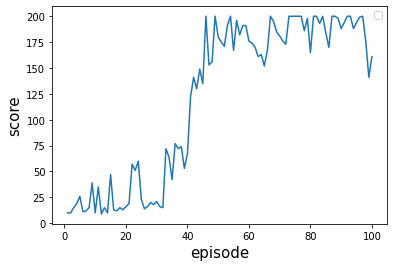

In [14]:
import matplotlib.pyplot as plt

x = range(1, episodes + 1)
withoutCopy = scores
# copy = scores1

fig, ax = plt.subplots()

line1, = ax.plot(x, withoutCopy)
# line1.set_dashes([2, 2, 10, 2])  
# line2, = ax.plot(x, withCopy, label='copy')
ax.set_xlabel(r'episode', fontsize=15)
ax.set_ylabel(r'score', fontsize=15)

ax.legend()
plt.show()

In [8]:
agent.save()

In [19]:
from tensorflow.keras import models
class DQNAgentWithCopy(DQNAgent):
    def copy(self, model):
        self.target_model = models.clone_model(model)
        self.target_model.set_weights(model.get_weights())
        return self.target_model

agent1 = DQNAgentWithCopy(state_n, action_n)
agent1.path = './save/cartpole-dqn.h5'
episodes = 100
scores1 = []
for episode in range(1, episodes + 1): 
    state = env.reset()
    done = False
    score = 0  
#     while not done:
    for _ in range(200):
#             env.render()
        action = agent1.act(state)
        next_state, reward, done, _ = env.step(action)
        agent1.memorize(state, action, reward, next_state, done)
        state = next_state
        score += reward
        agent1.learn()
        if done: break
    scores1.append(score)
    print('Episode: {} Socre: {} '.format(episode, score))

Episode: 1 Socre: 14.0 
Episode: 2 Socre: 32.0 
Episode: 3 Socre: 12.0 
Episode: 4 Socre: 17.0 
Episode: 5 Socre: 13.0 
Episode: 6 Socre: 18.0 
Episode: 7 Socre: 12.0 
Episode: 8 Socre: 12.0 
Episode: 9 Socre: 18.0 
Episode: 10 Socre: 11.0 
Episode: 11 Socre: 10.0 
Episode: 12 Socre: 10.0 
Episode: 13 Socre: 14.0 
Episode: 14 Socre: 13.0 
Episode: 15 Socre: 9.0 
Episode: 16 Socre: 10.0 
Episode: 17 Socre: 30.0 
Episode: 18 Socre: 9.0 
Episode: 19 Socre: 9.0 
Episode: 20 Socre: 11.0 
Episode: 21 Socre: 11.0 
Episode: 22 Socre: 10.0 
Episode: 23 Socre: 10.0 
Episode: 24 Socre: 12.0 
Episode: 25 Socre: 9.0 
Episode: 26 Socre: 13.0 
Episode: 27 Socre: 93.0 
Episode: 28 Socre: 97.0 
Episode: 29 Socre: 97.0 
Episode: 30 Socre: 60.0 
Episode: 31 Socre: 73.0 
Episode: 32 Socre: 99.0 
Episode: 33 Socre: 109.0 
Episode: 34 Socre: 94.0 
Episode: 35 Socre: 152.0 
Episode: 36 Socre: 140.0 
Episode: 37 Socre: 100.0 
Episode: 38 Socre: 127.0 
Episode: 39 Socre: 103.0 
Episode: 40 Socre: 168.0 
Episod

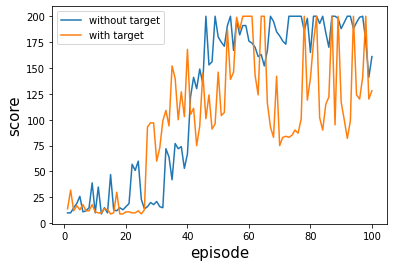

In [21]:
import matplotlib.pyplot as plt

x = range(1, episodes + 1)
withoutCopy = scores
copy = scores1

fig, ax = plt.subplots()

line1, = ax.plot(x, withoutCopy, label='without target')
# line1.set_dashes([2, 2, 10, 2])  
line2, = ax.plot(x, copy, label='with target')

ax.set_xlabel(r'episode', fontsize=15)
ax.set_ylabel(r'score', fontsize=15)

ax.legend()
plt.show()